GETTING DATA

Predict emotional valence from EEG using machine learning 

In [7]:
#imports

import pandas as pd
import numpy as np
import cmlreaders as cml
import matplotlib.pyplot as plt
import warnings
from Assignment3_Module import Log, LogDFException, StartFig, SaveFig, SubjectDataFrames, CMLReadDFRow, MakeLocationFilter, SubjectStats, SubjectStatTable
from Assignment3_Module import PowerSpectra
from dask.distributed import wait, as_completed, progress
from Assignment3_Module import RunDask
from ptsa.data.filters import morlet
from ptsa.data.filters import ButterworthFilter
#from mne import time_frequency
from ptsa_plot.ptsa_plot.topo import topoplot
from Assignment3_Module import PowerSpectra
from scipy import stats
import copy

In [8]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

In [18]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pd.set_option('display.max_columns', 100)

In [10]:
#load dataframe for all sessions
df = cml.get_data_index()

#Specify which subject and experiment we want
sub = 'LTP093'
exp = 'ltpFR2'

#Find out the sessions for this subject
sessions = list(df[(df['subject']==sub) & (df['experiment']==exp)]['session'])

df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
df_sess = df_select.iloc[0]
print(df_sess)

# Initialize data reader using session metadata
reader = cml.CMLReader(subject=df_sess['subject'], experiment=df_sess['experiment'], session=df_sess['session'],
                       localization=df_sess['localization'], montage=df_sess['montage'])

# For first session...
evs = reader.load("events")
print(evs[100:103])

Recognition                                                          NaN
all_events             protocols/ltp/subjects/LTP093/experiments/ltpF...
contacts                                                             NaN
experiment                                                        ltpFR2
import_type                                                        build
localization                                                           0
math_events            protocols/ltp/subjects/LTP093/experiments/ltpF...
montage                                                                0
original_experiment                                                  NaN
original_session                                                       0
pairs                                                                NaN
ps4_events                                                           NaN
session                                                                0
subject                                            

In [11]:
df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/ltp/subjects/LTP063/experiments/ltpF...,NaN,ltpFR,build,0,protocols/ltp/subjects/LTP063/experiments/ltpF...,0,NaN,0,NaN,NaN,0,LTP063,LTP063,NaN,protocols/ltp/subjects/LTP063/experiments/ltpF...
1,NaN,protocols/ltp/subjects/LTP063/experiments/ltpF...,NaN,ltpFR,build,0,protocols/ltp/subjects/LTP063/experiments/ltpF...,0,NaN,1,NaN,NaN,1,LTP063,LTP063,NaN,protocols/ltp/subjects/LTP063/experiments/ltpF...
2,NaN,protocols/ltp/subjects/LTP063/experiments/ltpF...,NaN,ltpFR,build,0,protocols/ltp/subjects/LTP063/experiments/ltpF...,0,NaN,10,NaN,NaN,10,LTP063,LTP063,NaN,protocols/ltp/subjects/LTP063/experiments/ltpF...
3,NaN,protocols/ltp/subjects/LTP063/experiments/ltpF...,NaN,ltpFR,build,0,protocols/ltp/subjects/LTP063/experiments/ltpF...,0,NaN,11,NaN,NaN,11,LTP063,LTP063,NaN,protocols/ltp/subjects/LTP063/experiments/ltpF...
4,NaN,protocols/ltp/subjects/LTP063/experiments/ltpF...,NaN,ltpFR,build,0,protocols/ltp/subjects/LTP063/experiments/ltpF...,0,NaN,12,NaN,NaN,12,LTP063,LTP063,NaN,protocols/ltp/subjects/LTP063/experiments/ltpF...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,NaN,NaN,NaN,pyFR,NaN,0,NaN,0,NaN,NaN,NaN,NaN,2,UP045,NaN,NaN,NaN
374,NaN,NaN,NaN,pyFR,NaN,0,NaN,0,NaN,NaN,NaN,NaN,3,UP045,NaN,NaN,NaN
375,NaN,NaN,NaN,pyFR,NaN,0,NaN,0,NaN,NaN,NaN,NaN,0,UP046,NaN,NaN,NaN
376,NaN,NaN,NaN,pyFR,NaN,0,NaN,0,NaN,NaN,NaN,NaN,1,UP046,NaN,NaN,NaN


In [12]:
word_evs = evs[evs['type']=='WORD']
word_evs[:10]

,eegoffset,answer,begin_distractor,begin_math_correct,eegfile,eogArtifact,experiment,final_distractor,final_math_correct,intruded,intrusion,iscorrect,item_name,item_num,list,montage,msoffset,mstime,phase,protocol,recalled,rectime,serialpos,session,subject,test,trial,type
6,285929,-999,0,-999,/protocols/ltp/subjects/LTP093/experiments/ltp...,1,ltpFR2,24000,10,0,-999,-999,BALLOON,75,-999,0,1,1409671137192,,ltp,1,-999,1,0,LTP093,"[0, 0, 0]",1,WORD
7,287177,-999,0,-999,/protocols/ltp/subjects/LTP093/experiments/ltp...,0,ltpFR2,24000,10,0,-999,-999,MAILBOX,857,-999,0,1,1409671139687,,ltp,1,-999,2,0,LTP093,"[0, 0, 0]",1,WORD
8,288442,-999,0,-999,/protocols/ltp/subjects/LTP093/experiments/ltp...,0,ltpFR2,24000,10,0,-999,-999,FLOWER,584,-999,0,1,1409671142218,,ltp,1,-999,3,0,LTP093,"[0, 0, 0]",1,WORD
9,289815,-999,0,-999,/protocols/ltp/subjects/LTP093/experiments/ltp...,3,ltpFR2,24000,10,0,-999,-999,DAUGHTER,442,-999,0,1,1409671144963,,ltp,1,-999,4,0,LTP093,"[0, 0, 0]",1,WORD
10,291179,-999,0,-999,/protocols/ltp/subjects/LTP093/experiments/ltp...,0,ltpFR2,24000,10,0,-999,-999,BLUEPRINT,142,-999,0,1,1409671147692,,ltp,1,-999,5,0,LTP093,"[0, 0, 0]",1,WORD
11,292403,-999,0,-999,/protocols/ltp/subjects/LTP093/experiments/ltp...,0,ltpFR2,24000,10,0,-999,-999,TRACTOR,1493,-999,0,1,1409671150140,,ltp,1,-999,6,0,LTP093,"[0, 0, 0]",1,WORD
12,293751,-999,0,-999,/protocols/ltp/subjects/LTP093/experiments/ltp...,0,ltpFR2,24000,10,0,-999,-999,SCALPEL,1243,-999,0,1,1409671152835,,ltp,1,-999,7,0,LTP093,"[0, 0, 0]",1,WORD
13,294999,-999,0,-999,/protocols/ltp/subjects/LTP093/experiments/ltp...,0,ltpFR2,24000,10,0,-999,-999,ZEBRA,1635,-999,0,1,1409671155331,,ltp,0,-999,8,0,LTP093,"[0, 0, 0]",1,WORD
14,296347,-999,0,-999,/protocols/ltp/subjects/LTP093/experiments/ltp...,0,ltpFR2,24000,10,0,-999,-999,PALACE,1006,-999,0,1,1409671158028,,ltp,1,-999,9,0,LTP093,"[0, 0, 0]",1,WORD
15,297653,-999,0,-999,/protocols/ltp/subjects/LTP093/experiments/ltp...,2,ltpFR2,24000,10,0,-999,-999,KLEENEX,782,-999,0,1,1409671160640,,ltp,1,-999,10,0,LTP093,"[0, 0, 0]",1,WORD


In [15]:
eeg = reader.load_eeg(events=word_evs, rel_start=0, rel_stop=500, clean=True)
eeg_ptsa = eeg.to_ptsa().channel.values

Opening raw data file /protocols/ltp/subjects/LTP093/experiments/ltpFR2/sessions/0/ephys/current_processed/LTP093 20140902 0959.2_clean_raw.fif...
    Range : 0 ... 2858664 =      0.000 ...  5717.328 secs
Ready.
Reading 0 ... 2858664  =      0.000 ...  5717.328 secs...
576 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 576 events and 251 original time points ...
0 bad epochs dropped


In [16]:
def GetElectrodes(sub):
    df_sub = SubjectDataFrames(sub)
    reader = CMLReadDFRow(next(df_sub.itertuples()))
    evs = reader.load('events')
    enc_evs = evs[evs.type=='WORD']
    rec_evs = evs[evs.type=='REC_WORD']
    eeg = reader.load_eeg(events=enc_evs, rel_start=0, rel_stop=500, clean=True)
    return eeg.to_ptsa().channel.values, enc_evs, rec_evs

In [19]:
all_scalp_electrodes, all_enc_evs, all_rec_evs = GetElectrodes(sub)
print(len(all_scalp_electrodes), 'electrodes found:')
print(all_scalp_electrodes)

Opening raw data file /protocols/ltp/subjects/LTP093/experiments/ltpFR2/sessions/0/ephys/current_processed/LTP093 20140902 0959.2_clean_raw.fif...
    Range : 0 ... 2858664 =      0.000 ...  5717.328 secs
Ready.
Reading 0 ... 2858664  =      0.000 ...  5717.328 secs...
576 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 576 events and 251 original time points ...
0 bad epochs dropped
124 electrodes found:
['E1' 'E2' 'E3' 'E4' 'E5' 'E6' 'E7' 'E9' 'E10' 'E11' 'E12' 'E13' 'E14'
 'E15' 'E16' 'E17' 'E18' 'E19' 'E20' 'E21' 'E22' 'E23' 'E24' 'E26' 'E27'
 'E28' 'E29' 'E30' 'E31' 'E32' 'E33' 'E34' 'E35' 'E36' 'E37' 'E38' 'E39'
 'E40' 'E41' 'E42' 'E43' 'E44' 'E45' 'E46' 'E47' 'E48' 'E49' 'E50' 'E51'
 'E52' 'E53' 'E54' 'E55' 'E56' 'E57' 'E58' 'E59' 'E60' 'E61' 'E62' 'E63'
 'E64' 'E65' 'E66' 'E67' 'E68' 'E69' 'E70' 'E71' 'E72' 'E73' 'E74' 'E75'
 'E76' 'E77' 'E78' 'E79' 'E80' 'E81' 'E82' 'E83' 'E84' 'E85' 'E86' 'E87'
 'E88' 'E8

In [15]:
word_idx = np.where(all_enc_evs.item_name.values == "BALLOON")[0][0]

In [11]:
all_scalp_electrodes[0]

'E1'

In [12]:
word_idx = np.where(all_enc_evs.item_name.values == "BALLOON")[0][0]
item_num = all_enc_evs.item_num.values[word_idx]
print(item_num)

word_idx = np.where(all_rec_evs.item_name.values == "BALLOON")[0][0]
item_num = all_rec_evs.item_num.values[word_idx]

print(item_num)

75
75


In [18]:
import os
os.getcwd()

df_val= pd.read_csv('/home1/arinaa/COGS4390_DataMemoryBrains/Aka_ltpFR2_wordpool - Sheet1.csv')

In [14]:
all_scalp_electrodes

array(['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E9', 'E10', 'E11',
       'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20',
       'E21', 'E22', 'E23', 'E24', 'E26', 'E27', 'E28', 'E29', 'E30',
       'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39',
       'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48',
       'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57',
       'E58', 'E59', 'E60', 'E61', 'E62', 'E63', 'E64', 'E65', 'E66',
       'E67', 'E68', 'E69', 'E70', 'E71', 'E72', 'E73', 'E74', 'E75',
       'E76', 'E77', 'E78', 'E79', 'E80', 'E81', 'E82', 'E83', 'E84',
       'E85', 'E86', 'E87', 'E88', 'E89', 'E90', 'E91', 'E92', 'E93',
       'E94', 'E95', 'E96', 'E97', 'E98', 'E99', 'E100', 'E101', 'E102',
       'E103', 'E104', 'E105', 'E106', 'E107', 'E108', 'E109', 'E110',
       'E111', 'E112', 'E113', 'E114', 'E115', 'E116', 'E117', 'E118',
       'E119', 'E120', 'E121', 'E122', 'E123', 'E124', 'E125', 'E128'],
      dtype='<

In [15]:
all_enc_evs.shape

(576, 28)

In [16]:
plt.hist([v.iloc[0] for v in get_val(df, all_enc_evs, all_enc_evs.item_name.values)])
plt.show()

NameError: name 'get_val' is not defined

In [20]:
def get_val(df, ptsa, wlist):
    
    val_list = []
    
    for word in wlist:
        word_idx = np.where(ptsa.item_name.values == word)[0][0]

        item_num = ptsa.item_num.values[word_idx]
        
        selected_rows = df_val[df_val['Word ID in ltpFR Wordpool'] == item_num]
        val_list.append(selected_rows['Valence'])   
        
    return val_list

In [21]:
#item_num
def get_word_info( word, rec):
    
    if rec:
        try:
            word_idx = np.where(rec_eeg_ptsa.item_name.values == word)[0][0]
            item_num = eeg_ptsa.item_num.values[word_idx]
            print("item number", item_num)
            EEG = rec_eeg_ptsa[word_idx,0,:]
        except Exception as e:
            print(f"Error: {e}. Word was not recalled")
            return
        
        
    else:
        word_idx = np.where(eeg_ptsa.item_name.values == word)[0][0]
        item_num = eeg_ptsa.item_num.values[word_idx]
        print("item number", item_num)
        
        #EEG for channel E1
        EEG = eeg_ptsa[word_idx,0,:]
    
    #valence using csv file from Aka et al., 2021
    selected_rows = df_1[df_1['Word ID in ltpFR Wordpool'] == item_num]
    val = selected_rows['Valence']
    print("emotional valence", val)   
            
    
    print("EEG: ", EEG)

In [22]:
import pickle

In [23]:
with open('zdata/data_good.pickle', 'rb') as handle:
    (subject_rec_state,subject_log_power,subject_valence) = pickle.load( handle)

In [18]:
def CreateDataset(subjects, electrodes, freqs, avg_ref=False, ref_region_idx=None,
                 log_power=False, zscore=False, exp='ltpFR2',
                 bin_elecs=True, internal_bipolar=False, use_pairs=True,
                 elec_masks=False, debug=False):

    buf_ms = 1000
    range_left_ms = 0
    range_right_ms = 1600
    morlet_reps = 6
    subject_rec_state = []
    subject_log_power = []
    subject_valence = []

    
    for sub in subjects:
        df_sub = SubjectDataFrames(sub, exp).iloc[:1] if debug else SubjectDataFrames(sub, exp)
        
        
        sub_rec_powers = np.zeros(len(freqs))
        sub_nrec_powers = np.zeros(len(freqs))
        
        
        session_log_power = [] 
        session_rec_state = [] 
        session_valence = [] 
        
        
        first_run = True
        first_channel_flags = None
        num_channels_found = 0
        df_per_sub = 0
        mask_index = -1
        
        
        
        for row in df_sub.itertuples():
            mask_index += 1
            try:
                reader = CMLReadDFRow(row)
                evs = reader.load('events')
                enc_evs = evs[evs.type=='WORD']
               
                if use_pairs: scheme = reader.load('pairs')
                else:
                    if row.experiment in ['FR1', 'catFR1']: 
                        scheme = reader.load('contacts')
                    else: scheme = None
                    
                    
                eeg = reader.load_eeg(events=enc_evs, rel_start=-range_left_ms - buf_ms, \
                    rel_stop=range_right_ms + buf_ms, clean=True, scheme=scheme)
                
                if len(eeg.events) != enc_evs.shape[0]:
                    raise IndexError(str(len(eeg.events)) + ' eeg events for ' + \
                                     str(enc_evs.shape[0]) + ' encoding events')
            
                if avg_ref:
                    if ref_region_idx is not None:
                        # reference to average of regional averages
#                         print('region-weighted average referencing')
                        avg_ref_data = np.zeros((eeg.data.shape[0], eeg.data.shape[2]))  # events x time
                        num_regions = 0
                        for sess_reg_idx in ref_region_idx:
                            reg_mask = sess_reg_idx[mask_index]  # get region mask for session
                            if sum(reg_mask) < 5: continue
#                             print('here', reg_mask)
                            if isinstance(reg_mask, np.ndarray): reg_mask = reg_mask.tolist()
#                             print('here2')
                            avg_ref_data += eeg.data[:,reg_mask,:].mean(axis=1)  # add in regional average
#                             print(avg_ref_data.shape)
                            num_regions += 1
                        avg_ref_data /= num_regions
                    else:
                        # Reference to average
                        avg_ref_data = np.mean(eeg.data, (1))
                    for i in range(eeg.data.shape[1]):
                        eeg.data[:,i,:] = eeg.data[:,i,:] - avg_ref_data
                
                if internal_bipolar:
                    # Bipolar reference to nearest labeled electrode
                    eeg.data -= np.roll(eeg.data, 1, 1)

                sr = eeg.samplerate
                print('sampling rate (Hz)',sr)
            
                eeg_ptsa = eeg.to_ptsa()
                valences = get_val(df_val, eeg_ptsa, eeg_ptsa.item_name.values )
            
                del eeg
                
                channels = eeg_ptsa.channel.values
                channel_flags = [( True) for c in channels]
                
                
               
                eeg_chan = eeg_ptsa[:,channel_flags,:]
#                 print('after eeg_chan')
                del eeg_ptsa
                
                freq_range = [58., 62.]
                b_filter = ButterworthFilter(freq_range=freq_range, filt_type='stop', order=4)
                eeg_filtered = b_filter.filter(eeg_chan)
                del eeg_chan
                
#                 print(eeg_filtered.time)
                wf = morlet.MorletWaveletFilter(freqs=freqs, width=morlet_reps, 
                                                output='power', complete=True)
                powers_plusbuf = wf.filter(eeg_filtered)
                del eeg_filtered
            
                # remove buffer
                # freqs, events, elecs, and time
                powers = powers_plusbuf[:, :, :, int((buf_ms/1000)*sr):-1*int((buf_ms/1000)*sr)]
                del powers_plusbuf
                
                if log_power:
                    powers = np.log10(powers)
                
                # Average over time
                powers = np.mean(powers, (3))
                
                session_log_power.append(powers)
                session_rec_state.append(enc_evs.recalled.tolist())
                session_valence.append(valences)

    
            except Exception as e:
                print(e)
                print("problem")
                LogDFException(row, e)
                for pp in range(10):
                    print(e)
                
                if debug: raise e       
        
        subject_rec_state.append(session_rec_state)
        subject_log_power.append(session_log_power)      
        subject_valence.append(session_valence)
        
        with open('data.pickle2', 'wb') as handle:
            pickle.dump((subject_rec_state,subject_log_power,subject_valence ), handle)
        
    return (subject_log_power, subject_rec_state, subject_valence)

In [ ]:
recompute = False

if recompute:
    subs = df[df['experiment']=='ltpFR2']['subject'].unique()
    freqs = np.logspace(np.log10(3), np.log10(180),8)
    subject_log_power, subject_rec_state, subject_valence =  CreateDataset(subs, [], freqs, use_pairs=False)

In [368]:
#len(subject_rec_state),subject_log_power,subject_valence
sub_id = 0
session_id = 5
freqnb = 8
channelnb = 124

rec_session = np.array(subject_rec_state[sub_id][session_id])

data_session = np.transpose(subject_log_power[sub_id][session_id].data, (0,2,1))
data_session_z = stats.zscore(data_session,1)

valence_session = np.array([v.iloc[0] for v in subject_valence[sub_id][session_id]])

In [369]:

rec_all_session = np.array(subject_rec_state[sub_id][:]).flatten()
data_all_session = np.concatenate([np.transpose(subject_log_power[sub_id][v].data,
              (0,2,1)) for v in range(len(subject_log_power[sub_id]))],2)
data_all_session_z = stats.zscore(data_all_session,1)

list_val = []
for sess in range(len(subject_valence[sub_id])):
    list_val.extend([ (pd.Series.to_numpy(v)[0] if len(pd.Series.to_numpy(v))>0 else -1) for v in subject_valence[sub_id][sess]])
valence_all_session = np.array(list_val)

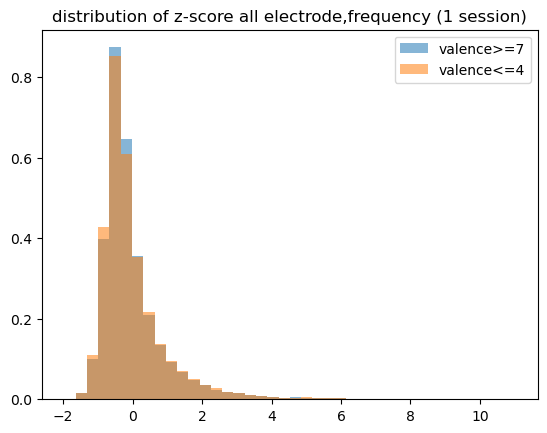

In [204]:
n, bins, patches = plt.hist(data_session_z[:,:,valence_session>=7].flatten(), bins=40, density=True, label="valence>=7", alpha=0.54)
plt.hist(data_session_z[:,:,valence_session<=4].flatten(), bins=bins,density=True, label="valence<=4", alpha=0.54)
plt.title("distribution of z-score all electrode,frequency (1 session)")
plt.legend()
plt.show()

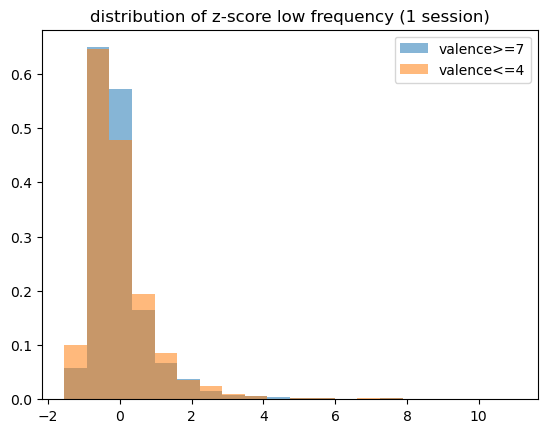

In [205]:
n, bins, patches = plt.hist(data_session_z[0][:,valence_session>=7].flatten(), bins=40, density=True, label="valence>=7", alpha=0.54)
plt.hist(data_session_z[0][:,valence_session<=4].flatten(), bins=bins,density=True, label="valence<=4", alpha=0.54)
plt.title("distribution of z-score low frequency (1 session)")
plt.legend()
plt.show()

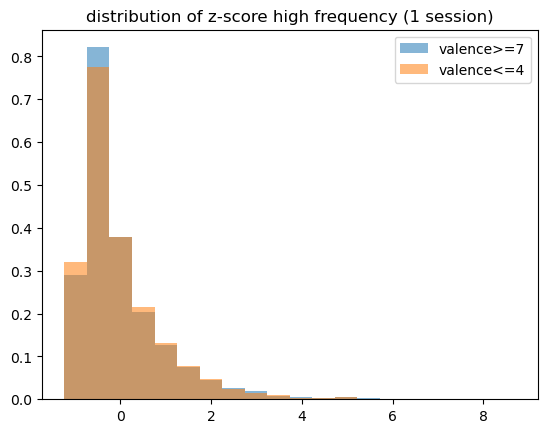

In [206]:
n, bins, patches = plt.hist(data_session_z[7][:,valence_session>=7].flatten(), bins=20, density=True, label="valence>=7", alpha=0.54)
plt.hist(data_session_z[7][:,valence_session<=4].flatten(), bins=bins,density=True, label="valence<=4", alpha=0.54)
plt.title("distribution of z-score high frequency (1 session)")
plt.legend()
plt.show()

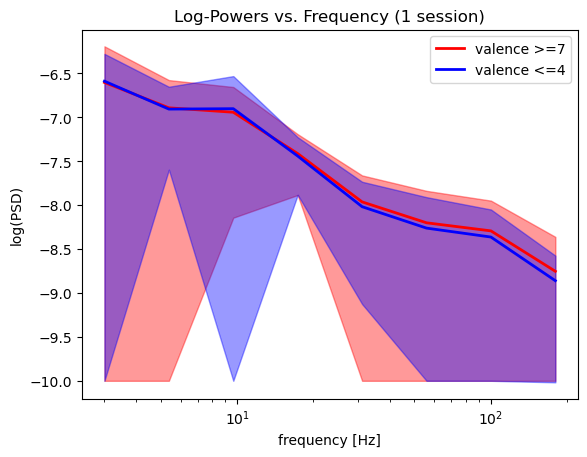

In [207]:
low_val = 4
high_val = 7


temp = data_session[:,:,valence_session>=high_val]
mean_temp = np.mean(temp.reshape(8,temp.shape[1]*temp.shape[2]),1)
std_temp = np.std(temp.reshape(8,temp.shape[1]*temp.shape[2]),1)
bot = [m-var if m-var>0 else 1E-10 for m,var in zip(mean_temp,std_temp)]
top = [m+var for m,var in zip(mean_temp,std_temp)]


plt.semilogx(freqs, np.log10(mean_temp),
             linewidth=2, label=f"valence >={high_val}", color='red')
plt.fill_between(freqs, np.log10(bot), np.log10(top), color='red', alpha=0.4)





temp = data_session[:,:,valence_session<=low_val]
mean_temp = np.mean(temp.reshape(8,temp.shape[1]*temp.shape[2]),1)
std_temp = np.std(temp.reshape(8,temp.shape[1]*temp.shape[2]),1)
bot = [m-var if m-var>0 else 1E-10 for m,var in zip(mean_temp,std_temp)]
top = [m+var for m,var in zip(mean_temp,std_temp)]




plt.semilogx(freqs, np.log10(mean_temp),
             linewidth=2, label=f"valence <={low_val}", color='blue')
plt.fill_between(freqs, np.log10(bot), np.log10(top), color='blue', alpha=0.4)


plt.title('Log-Powers vs. Frequency (1 session)')
plt.ylabel('log(PSD)')
plt.xlabel('frequency [Hz]')
plt.legend()
plt.show()

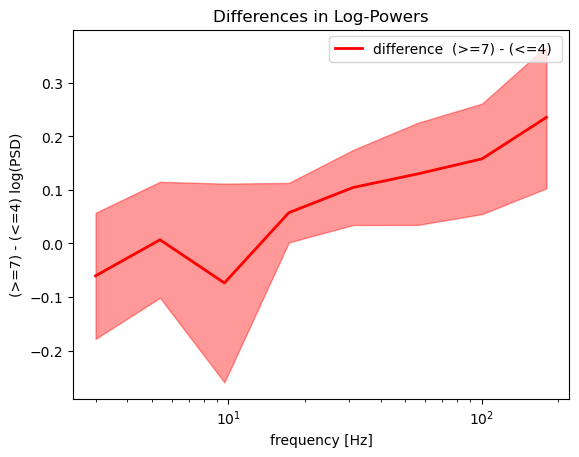

In [208]:
low_val = 4
high_val = 7


temp_high = np.log(np.mean(data_session[:,:,valence_session>=high_val],2))
temp_low = np.log(np.mean(data_session[:,:,valence_session<=low_val],2))

temp = temp_high-temp_low
mean_temp = np.mean(temp,1)
std_temp = np.std(temp,1)
bot = [m-var for m,var in zip(mean_temp,std_temp)]
top = [m+var for m,var in zip(mean_temp,std_temp)]

plt.semilogx(freqs, mean_temp,
             linewidth=2, label=f"difference  (>=7) - (<=4) ", color='red')
plt.fill_between(freqs, bot, top, color='red', alpha=0.4)


plt.ylabel('(>=7) - (<=4) log(PSD)')
plt.xlabel('frequency [Hz]')
plt.legend()
plt.title('Differences in Log-Powers')
plt.show()

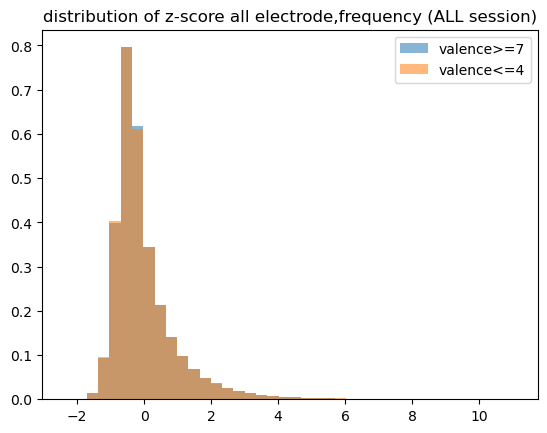

In [304]:
n, bins, patches = plt.hist(data_all_session_z[:,:,valence_all_session>=7].flatten(), bins=40, density=True, label="valence>=7", alpha=0.54)
plt.hist(data_all_session_z[:,:,valence_all_session<=4].flatten(), bins=bins,density=True, label="valence<=4", alpha=0.54)
plt.title("distribution of z-score all electrode,frequency (ALL session)")
plt.legend()
plt.show()

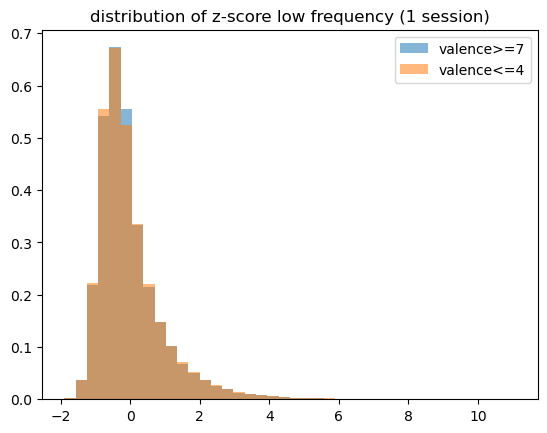

In [305]:
n, bins, patches = plt.hist(data_all_session_z[0][:,valence_all_session>=7].flatten(), bins=40, density=True, label="valence>=7", alpha=0.54)
plt.hist(data_all_session_z[0][:,valence_all_session<=4].flatten(), bins=bins,density=True, label="valence<=4", alpha=0.54)
plt.title("distribution of z-score low frequency (ALL session)")
plt.legend()
plt.show()

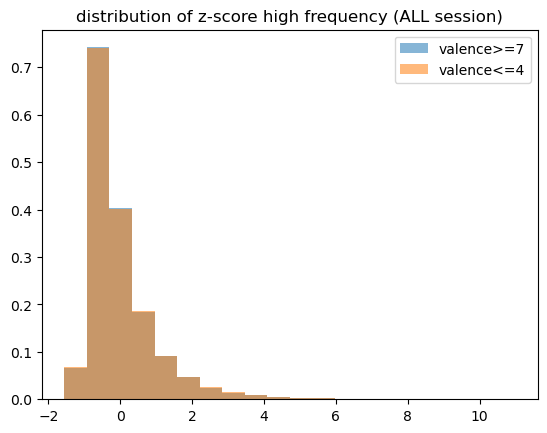

In [306]:
n, bins, patches = plt.hist(data_all_session_z[7][:,valence_all_session>=7].flatten(), bins=40, density=True, label="valence>=7", alpha=0.54)
plt.hist(data_all_session_z[7][:,valence_all_session<=4].flatten(), bins=bins,density=True, label="valence<=4", alpha=0.54)
plt.title("distribution of z-score high frequency (ALL session)")
plt.legend()
plt.show()

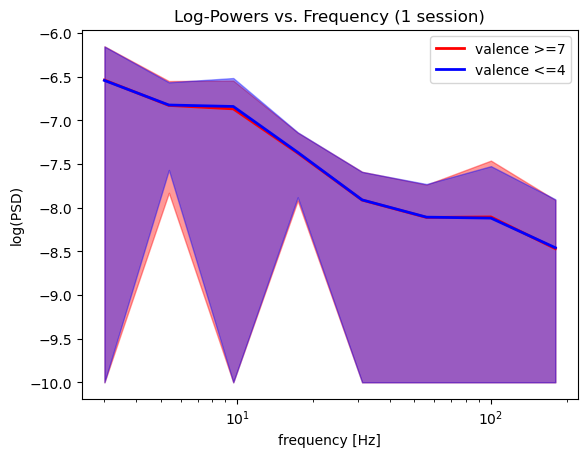

In [307]:
low_val = 4
high_val = 7


temp = data_all_session[:,:,valence_all_session>=high_val]
mean_temp = np.mean(temp.reshape(8,temp.shape[1]*temp.shape[2]),1)
std_temp = np.std(temp.reshape(8,temp.shape[1]*temp.shape[2]),1)
bot = [m-var if m-var>0 else 1E-10 for m,var in zip(mean_temp,std_temp)]
top = [m+var for m,var in zip(mean_temp,std_temp)]


plt.semilogx(freqs, np.log10(mean_temp),
             linewidth=2, label=f"valence >={high_val}", color='red')
plt.fill_between(freqs, np.log10(bot), np.log10(top), color='red', alpha=0.4)





temp = data_all_session[:,:,valence_all_session<=low_val]
mean_temp = np.mean(temp.reshape(8,temp.shape[1]*temp.shape[2]),1)
std_temp = np.std(temp.reshape(8,temp.shape[1]*temp.shape[2]),1)
bot = [m-var if m-var>0 else 1E-10 for m,var in zip(mean_temp,std_temp)]
top = [m+var for m,var in zip(mean_temp,std_temp)]




plt.semilogx(freqs, np.log10(mean_temp),
             linewidth=2, label=f"valence <={low_val}", color='blue')
plt.fill_between(freqs, np.log10(bot), np.log10(top), color='blue', alpha=0.4)


plt.title('Log-Powers vs. Frequency (1 session)')
plt.ylabel('log(PSD)')
plt.xlabel('frequency [Hz]')
plt.legend()
plt.show()

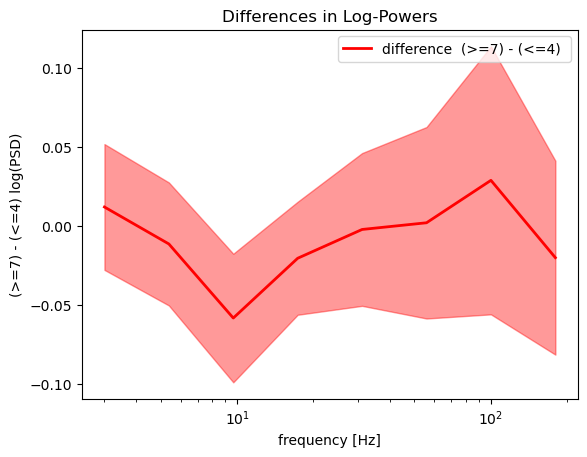

In [308]:
low_val = 4
high_val = 7


temp_high = np.log(np.mean(data_all_session[:,:,valence_all_session>=high_val],2))
temp_low = np.log(np.mean(data_all_session[:,:,valence_all_session<=low_val],2))

temp = temp_high-temp_low
mean_temp = np.mean(temp,1)
std_temp = np.std(temp,1)
bot = [m-var for m,var in zip(mean_temp,std_temp)]
top = [m+var for m,var in zip(mean_temp,std_temp)]

plt.semilogx(freqs, mean_temp,
             linewidth=2, label=f"difference  (>=7) - (<=4) ", color='red')
plt.fill_between(freqs, bot, top, color='red', alpha=0.4)


plt.ylabel('(>=7) - (<=4) log(PSD)')
plt.xlabel('frequency [Hz]')
plt.legend()
plt.title('Differences in Log-Powers')
plt.show()


In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from functools import reduce
from operator import concat
import pickle
from sklearn import linear_model
alpha_list = np.logspace(-6,2,10)

In [318]:
subject_log_power[0][0].shape

(8, 576, 124)

In [338]:
X_Y_pairs = []
#(subject_log_power, subject_rec_state, subject_valence)

for sub in range(len(subject_rec_state)):
    
    all_session = subject_log_power[sub]
    all_session_y = subject_valence[sub]
    
    all_session_concatenated = []
    all_session_concatenated_y = []
    
    for sess in range(len(all_session)):
        one_session = all_session[sess]
        one_session_y = all_session_y[sess]
        
        n_freqs = one_session.shape[0]
        n_events = one_session.shape[1]
        n_elecs = one_session.shape[2]
        
        one_session.transpose('event', 'frequency',  'channel')
        one_session = np.array(one_session)
        one_session = one_session.reshape(n_events, n_freqs*n_elecs)
        
        
        new_y = np.array(one_session_y).flatten()
        
        if type(new_y[0]) == pd.core.series.Series:
            print("we don't have the valence must drop")
            
        else:
            all_session_concatenated_y.append(new_y) 
            all_session_concatenated.append( stats.zscore(one_session, axis=0))
        
    X_Y_pairs.append([all_session_concatenated, all_session_concatenated_y])

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop


In [ ]:
score_optim = []
score_alpha1 = []

for sub in range(len(X_Y_pairs)):
    
    Xlist ,Ylist = X_Y_pairs[sub]
    score_sub_optim = []
    score_sub_alpha1 = []

    for k in range(len(Xlist)):

        X_test = Xlist[k]
        Y_test = Ylist[k]
        X_train = [Xlist[j] for j in range(len(Xlist)) if j!=k]
        Y_train = [Ylist[j] for j in range(len(Ylist)) if j!=k]  

        alpha_score = [[] for c in alpha_list]

        for l in range(len(X_train)):

            X_val_inner = Xlist[l]
            Y_val_inner = Ylist[l]
            X_train_inner = [X_train[j] for j in range(len(X_train)) if j!=l]
            Y_train_inner = [Y_train[j] for j in range(len(Y_train)) if j!=l]

            for alpha_ind,alpha in enumerate(alpha_list):

                lr_ridge = linear_model.Ridge(alpha=alpha)
                lr_ridge.fit(np.concatenate(X_train_inner), np.concatenate(Y_train_inner))
                alpha_score[alpha_ind].append(lr_ridge.score(X_val_inner, Y_val_inner))

        alpha_score = [sum(alpha_score[alpha_ind]) for alpha_ind in range(len(alpha_list))]
        best_alpha = alpha_list[alpha_score.index(max(alpha_score))]

        lr_ridge = linear_model.Ridge(alpha=best_alpha)
        lr_ridge.fit(np.concatenate(X_train), np.concatenate(Y_train))
        score_sub_optim.append(lr_ridge.score(X_test, Y_test))
       
        lr_ridge = linear_model.Ridge(alpha=1)
        lr_ridge.fit(np.concatenate(X_train), np.concatenate(Y_train))
        score_sub_alpha1.append(lr_ridge.score(X_test, Y_test))

    score_optim.append(score_sub_optim)
    score_alpha1.append(score_sub_alpha1)
            
with open('score_optim.pickle', 'wb') as handle:
    pickle.dump(score_optim, handle)
with open('score_alpha.pickle', 'wb') as handle:
    pickle.dump(score_alpha1, handle)

In [372]:
with open('score_optim_good.pickle', 'rb') as handle:
        score_optim = pickle.load(handle)
        
with open('score_alpha_good.pickle', 'rb') as handle:
        score_alpha1 = pickle.load(handle)  
    

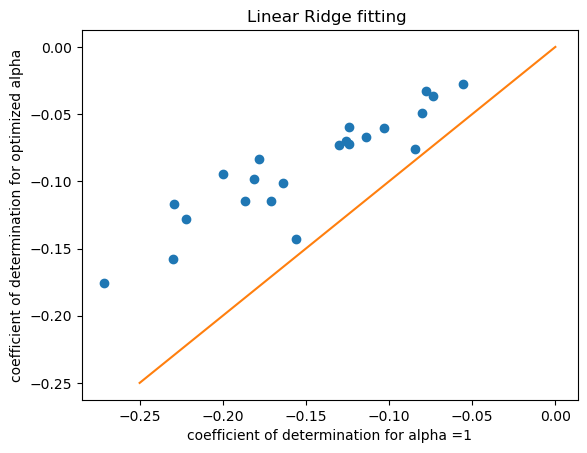

In [387]:
plt.plot(np.array(score_alpha1[0]).flatten(), np.array(score_optim[0]).flatten(),'o')
plt.plot([-0.25,0],[-0.25,0])
plt.title("Linear Ridge fitting ")
plt.ylabel("coefficient of determination for optimized alpha")
plt.xlabel("coefficient of determination for alpha =1")
plt.show()

In [417]:
Xlist ,Ylist = X_Y_pairs[0]
alpha = score_alpha1[0][0]

X_test = Xlist[0]
Y_test = Ylist[0]
X_train = [Xlist[j] for j in range(len(Xlist)) if j!=0]
Y_train = [Ylist[j] for j in range(len(Ylist)) if j!=0]  
lr_ridge = linear_model.Ridge(alpha=alpha)
lr_ridge.fit(np.concatenate(X_train), np.concatenate(Y_train))
predicted = lr_ridge.predict(X_test)

plt.plot(Y_test,predicted,'o')
plt.plot([1,9],[1,9])
plt.title("Example of fit from ridge")
plt.ylabel("valence predicted")
plt.xlabel("valence of word")
plt.show()

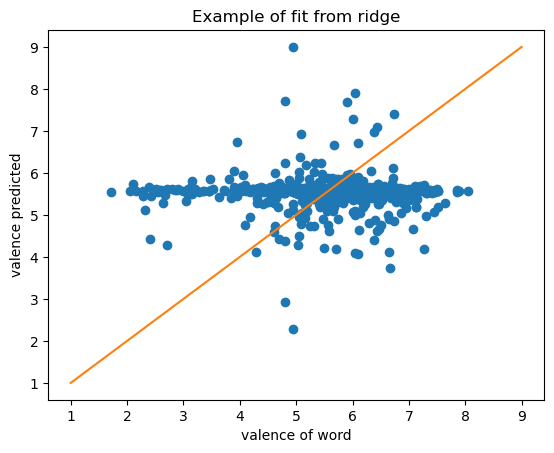

Can we at elast overfit the model???? answer:yes 

In [464]:
Xlist ,Ylist = X_Y_pairs[0]
Ylist = stats.zscore(Ylist)

alpha = score_alpha1[0][0]

X_test = Xlist[0]
Y_test = Ylist[0]
lr_ridge = linear_model.Ridge(alpha=0,solver='sparse_cg', tol=1e-8)
lr_ridge.fit(X_test, Y_test)
predicted = lr_ridge.predict(X_test)

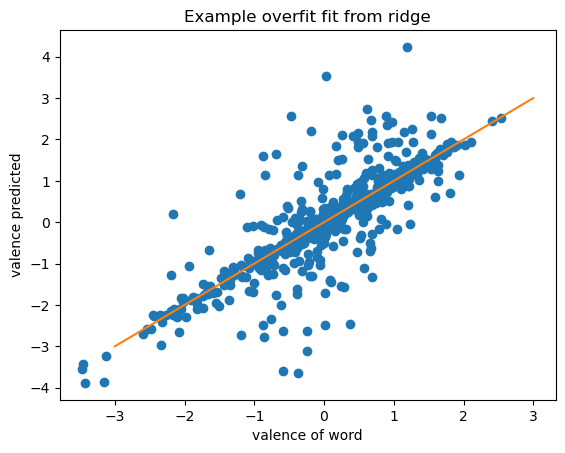

In [465]:
plt.plot(Y_test,predicted,'o')
plt.plot([-3,3],[-3,3])
plt.title("Example overfit fit from ridge")
plt.ylabel("valence predicted")
plt.xlabel("valence of word")
plt.show()

Can feature selection helps? 

In [146]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [618]:
Xlist ,Ylist = X_Y_pairs[0]
Ylist = stats.zscore(Ylist)

X_sel = Xlist[0]
Y_sel = Ylist[0]
X_test = Xlist[1]
Y_test = Ylist[1]

X_train = np.concatenate( [Xlist[j] for j in range(len(Xlist)) if j not in [0,1]])
Y_train = np.concatenate( [Ylist[j] for j in range(len(Ylist)) if j not in [0,1]]) 

sel = SelectKBest(mutual_info_regression, k=300)

X_sel_new = sel.fit_transform(X_sel, Y_sel)

X_test_new = sel.transform(X_test)
X_train_new = sel.transform(X_train)

In [619]:
lr_ridge = linear_model.Ridge(alpha=0.1)
lr_ridge.fit(X_train_new, Y_train)
predicted = lr_ridge.predict(X_test_new)

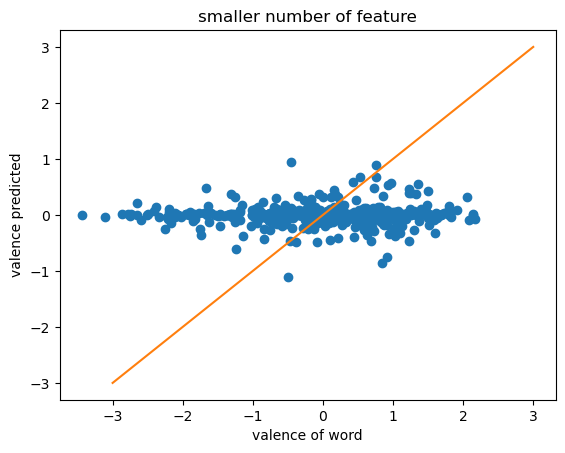

In [620]:
plt.plot(Y_test,predicted,'o')
plt.plot([-3,3],[-3,3])
plt.title("smaller number of feature")
plt.ylabel("valence predicted")
plt.xlabel("valence of word")
plt.show()

Can suport vector machine helps? 

In [145]:
from sklearn import svm
regr = svm.SVR( C=1000)

In [622]:
regr.fit(X_train, Y_train)

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

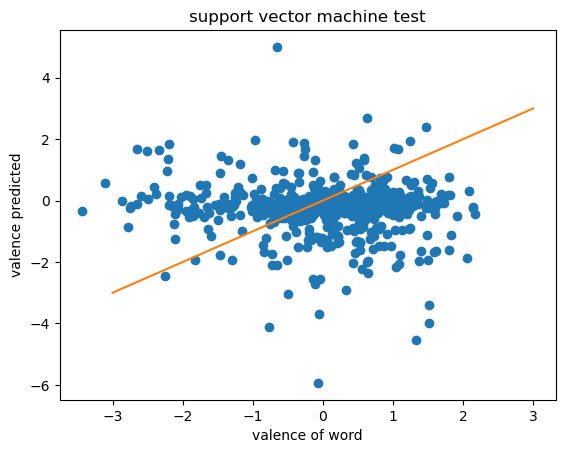

In [623]:
predicted = regr.predict(X_test)
plt.plot(Y_test,predicted,'o')
plt.plot([-3,3],[-3,3])
plt.title("support vector machine test")
plt.ylabel("valence predicted")
plt.xlabel("valence of word")
plt.show()

In [662]:
Xlist ,Ylist = X_Y_pairs[0]
Ylist = stats.zscore(Ylist)

X_sel = Xlist[0]
Y_sel = Ylist[0]
X_test = Xlist[1]
Y_test = Ylist[1]

X_train = np.concatenate( [Xlist[j] for j in range(len(Xlist)) if j not in [0,1]])
Y_train = np.concatenate( [Ylist[j] for j in range(len(Ylist)) if j not in [0,1]]) 

sel = SelectKBest(mutual_info_regression, k=50)

X_sel_new = sel.fit_transform(X_sel, Y_sel)

X_test_new = sel.transform(X_test)
X_train_new = sel.transform(X_train)

X_train_new_just_extreme = [] 
Y_train_just_extreme = []

for i in range(len(X_test_new)):
    yyy = Y_train[i]
    if yyy<-1or yyy>1:
        X_train_new_just_extreme.append(X_test_new[i,:])
        Y_train_just_extreme.append(yyy)

X_train_new_just_extreme = np.array(X_train_new_just_extreme)
Y_train_just_extreme = np.array(Y_train_just_extreme)

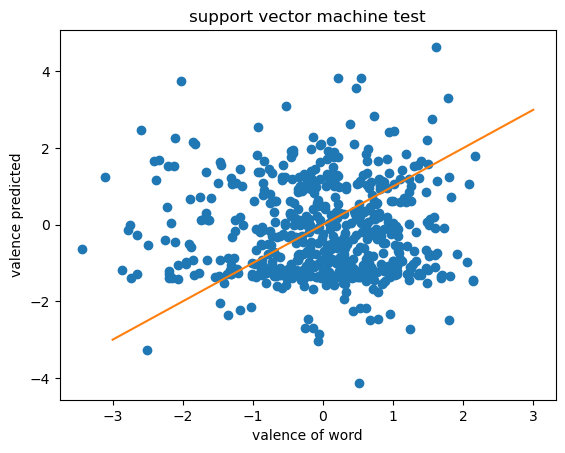

In [663]:
from sklearn import svm
regr = svm.SVR( C=100)
regr.fit(X_train_new_just_extreme, Y_train_just_extreme)
predicted = regr.predict(X_test_new)


plt.plot(Y_test,predicted,'o')
plt.plot([-3,3],[-3,3])

plt.title("support vector machine test")
plt.ylabel("valence predicted")
plt.xlabel("valence of word")
plt.show()

In [696]:
Xlist ,Ylist = X_Y_pairs[0]
Ylist = stats.zscore(Ylist)

X_sel = Xlist[0]
Y_sel = Ylist[0]
X_test = Xlist[1]
Y_test = Ylist[1]

X_train = np.concatenate( [Xlist[j] for j in range(len(Xlist)) if j not in [0,1]])
Y_train = np.concatenate( [Ylist[j] for j in range(len(Ylist)) if j not in [0,1]]) 

sel = SelectKBest(mutual_info_regression, k=500)

X_sel_new = sel.fit_transform(X_sel, Y_sel)

X_test_new = sel.transform(X_test)
X_train_new = sel.transform(X_train)

X_train_new_just_extreme = [] 
Y_train_just_extreme = []

for i in range(len(X_test_new)):
    yyy = Y_train[i]
    if yyy<-0 or yyy>0:
        X_train_new_just_extreme.append(X_test_new[i,:])
        Y_train_just_extreme.append(yyy)

X_train_new_just_extreme = np.array(X_train_new_just_extreme)
Y_train_just_extreme = np.array(Y_train_just_extreme)

-0.5793838335055552


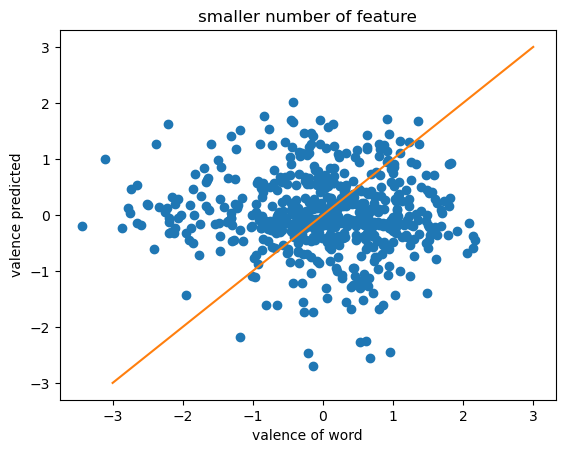

In [697]:
lr_ridge = linear_model.Ridge(alpha=0.1)
lr_ridge.fit(X_train_new_just_extreme, Y_train_just_extreme)
predicted = lr_ridge.predict(X_test_new)
print(lr_ridge.score(X_test_new, Y_test))
plt.plot(Y_test,predicted,'o')
plt.plot([-3,3],[-3,3])
plt.title("smaller number of feature")
plt.ylabel("valence predicted")
plt.xlabel("valence of word")
plt.show()

1. Improve modeling 2-layer network perhaps
2. Change the training data (more than 8 frequencies, what to keep form the eeg)
3. Change the question, perhaps binarize the 

In [2]:
import numpy as np

In [4]:
freqs = np.logspace(np.log10(3), np.log10(180),16)
freqs


array([  3.        ,   3.9415285 ,   5.17854898,   6.80379947,
         8.93912317,  11.74460292,  15.43056239,  20.27333382,
        26.63597437,  34.99548405,  45.97856594,  60.40860939,
        79.36741856, 104.27631414, 137.00268809, 180.        ])

In [83]:
buf_ms = 1000
range_left_ms = 0
range_right_ms = 1600
morlet_reps = 6
avg_ref=False 
ref_region_idx=None,          
log_power=False
zscore=False 
exp='ltpFR2'
bin_elecs=True
internal_bipolar=False
use_pairs=False
elec_masks=False
debug=False

subs = df[df['experiment']=='ltpFR2']['subject'].unique()
freqs = np.logspace(np.log10(3), np.log10(180),16)
    

time_window_average = [[65,110],[110,225],[225,290],[290,375],[375,670] ]    
time_window_frequency = [[0,300],[300,600],[600,1000]]    



eeg_filtered = 0

for sub in subs[0:1]:
    df_sub = SubjectDataFrames(sub, exp).iloc[:1] if debug else SubjectDataFrames(sub, exp)


    sub_rec_powers = np.zeros(len(freqs))
    sub_nrec_powers = np.zeros(len(freqs))


    session_log_power = [] 
    session_rec_state = [] 
    session_valence = [] 


    first_run = True
    first_channel_flags = None
    num_channels_found = 0
    df_per_sub = 0
    mask_index = -1



    for row in df_sub.itertuples():
        mask_index += 1

        reader = CMLReadDFRow(row)
        evs = reader.load('events')
        enc_evs = evs[evs.type=='WORD']

        if use_pairs: scheme = reader.load('pairs')
        else:
            if row.experiment in ['FR1', 'catFR1']: 
                scheme = reader.load('contacts')
            else: scheme = None


        eeg = reader.load_eeg(events=enc_evs, rel_start=-range_left_ms - buf_ms, \
            rel_stop=range_right_ms + buf_ms, clean=True, scheme=scheme)

        if len(eeg.events) != enc_evs.shape[0]:
            raise IndexError(str(len(eeg.events)) + ' eeg events for ' + \
                             str(enc_evs.shape[0]) + ' encoding events')

        if avg_ref:
            if ref_region_idx is not None:
                avg_ref_data = np.zeros((eeg.data.shape[0], eeg.data.shape[2]))  # events x time
                num_regions = 0
                for sess_reg_idx in ref_region_idx:
                    reg_mask = sess_reg_idx[mask_index]  # get region mask for session
                    if sum(reg_mask) < 5: continue
                    if isinstance(reg_mask, np.ndarray): reg_mask = reg_mask.tolist()
                    avg_ref_data += eeg.data[:,reg_mask,:].mean(axis=1)  # add in regional average
                    num_regions += 1
                avg_ref_data /= num_regions
            else:
                # Reference to average
                avg_ref_data = np.mean(eeg.data, (1))
            for i in range(eeg.data.shape[1]):
                eeg.data[:,i,:] = eeg.data[:,i,:] - avg_ref_data

        if internal_bipolar:
            # Bipolar reference to nearest labeled electrode
            eeg.data -= np.roll(eeg.data, 1, 1)

        sr = eeg.samplerate
        print('sampling rate (Hz)',sr)

        eeg_ptsa = eeg.to_ptsa()
        valences = get_val(df_val, eeg_ptsa, eeg_ptsa.item_name.values )

        del eeg

        channels = eeg_ptsa.channel.values
        channel_flags = [( True) for c in channels]



        eeg_chan = eeg_ptsa[:,channel_flags,:]
        del eeg_ptsa

        freq_range = [58., 62.]
        b_filter = ButterworthFilter(freq_range=freq_range, filt_type='stop', order=4)
        eeg_filtered = b_filter.filter(eeg_chan)
        del eeg_chan
        
        
        

        
        
        wf = morlet.MorletWaveletFilter(freqs=freqs, width=morlet_reps, 
                                        output='power', complete=True)
        powers_plusbuf = wf.filter(eeg_filtered)

        # remove buffer
        # freqs, events, elecs, and time
        powers = powers_plusbuf[:, :, :, int((buf_ms/1000)*sr):-1*int((buf_ms/1000)*sr)]

        if log_power:
            powers = np.log10(powers)

        # Average over time
        powers = np.mean(powers, (3))
        break

Opening raw data file /protocols/ltp/subjects/LTP093/experiments/ltpFR2/sessions/0/ephys/current_processed/LTP093 20140902 0959.2_clean_raw.fif...
    Range : 0 ... 2858664 =      0.000 ...  5717.328 secs
Ready.
Reading 0 ... 2858664  =      0.000 ...  5717.328 secs...
576 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 576 events and 1801 original time points ...
0 bad epochs dropped
sampling rate (Hz) 500
CPP total time wavelet loop:  38.91359877586365


In [97]:

time_window_average = [[65,110],[110,225],[225,290],[290,375],[375,670] ]    



range_right_ms 
eeg_filtered
#remove buffer
eeg_filtered_nobuff = eeg_filtered[:, :, int((buf_ms/1000)*sr):-1*int((buf_ms/1000)*sr)]
# event: 576 channel: 124 time: 801
nb_time = eeg_filtered_nobuff.shape[2]
time_window_average_id = [  [ int(nb_time*tw[0]/range_right_ms),int(nb_time*tw[1]/range_right_ms) ]   for tw in time_window_average] 
time_window_average_data = [ np.mean(eeg_filtered_nobuff[:,:, tw[0]:tw[1]], 2) for tw in time_window_average_id] 
time_window_average_data = np.stack(time_window_average_data,2)


powers = powers_plusbuf[:, :, :, int((buf_ms/1000)*sr):-1*int((buf_ms/1000)*sr)]
time_window_frequency_data = [ np.mean(powers[:,:,:, tw[0]:tw[1]], 3) for tw in time_window_average_id] 
time_window_frequency_data  = np.stack(time_window_frequency_data,3)






In [99]:
time_window_average_data.shape

(576, 124, 5)

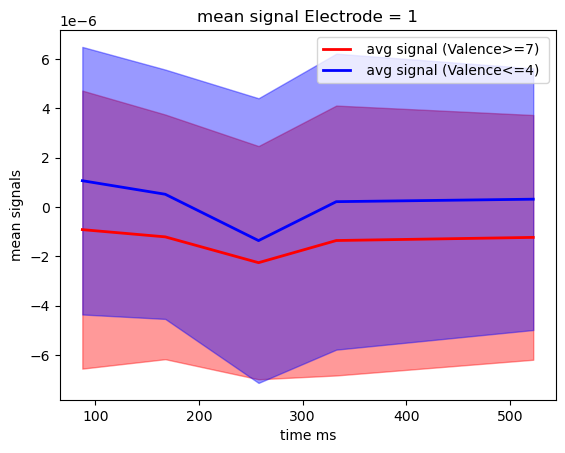

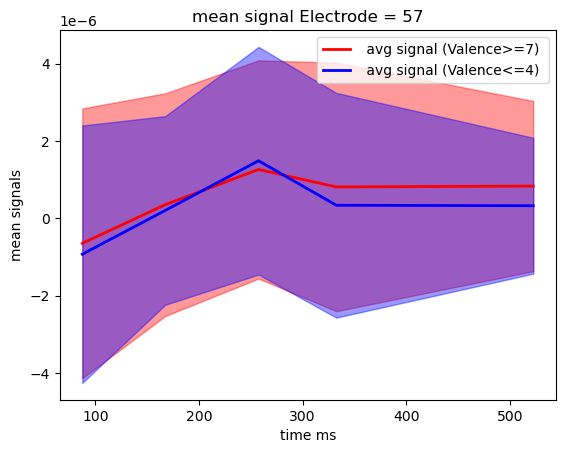

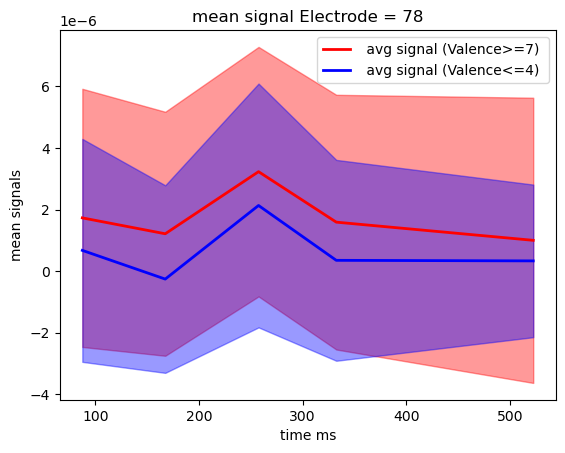

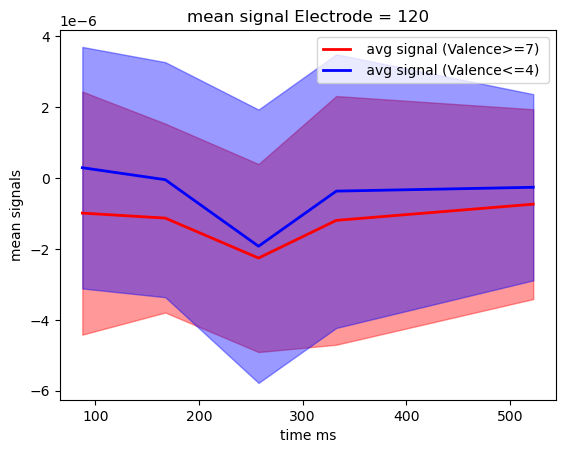

In [121]:
low_val = 4
high_val = 7


for electrode in [1,57,78,120]:

    temp_high = time_window_average_data[np.array(valences).flatten()>=high_val,:,:]
    temp_low = time_window_average_data[np.array(valences).flatten()<=low_val,:,:]

    temp_high = temp_high[:,electrode,:]
    temp_low = temp_low[:,electrode,:]

    tlist = [ 0.5*(t[0] + t[1]) for t in time_window_average]
    
    mean_temp = np.mean(temp_high,0)
    std_temp = np.std(temp_high,0)
    
    bot = [m-var for m,var in zip(mean_temp,std_temp)]
    top = [m+var for m,var in zip(mean_temp,std_temp)]
    plt.plot(tlist, mean_temp,
                 linewidth=2, label=f" avg signal (Valence>={high_val}) ", color='red')
    plt.fill_between(tlist, bot, top, color='red', alpha=0.4)
    
    mean_temp = np.mean(temp_low,0)
    std_temp = np.std(temp_low,0)
    
    bot = [m-var for m,var in zip(mean_temp,std_temp)]
    top = [m+var for m,var in zip(mean_temp,std_temp)]
    
    plt.plot(tlist, mean_temp,
                 linewidth=2, label=f" avg signal (Valence<={low_val}) ", color='blue')
    plt.fill_between(tlist, bot, top, color='blue', alpha=0.4)
    

    plt.ylabel('mean signals')
    plt.xlabel('time ms')
    plt.legend()
    plt.title(f'mean signal Electrode = {electrode}')
    plt.show()

In [122]:
time_window_frequency_data.shape

(16, 576, 124, 5)

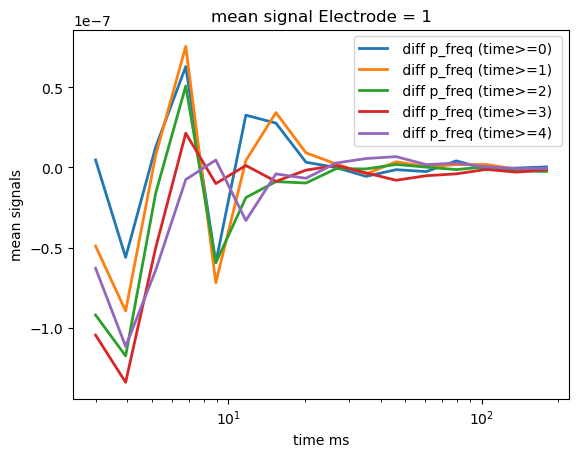

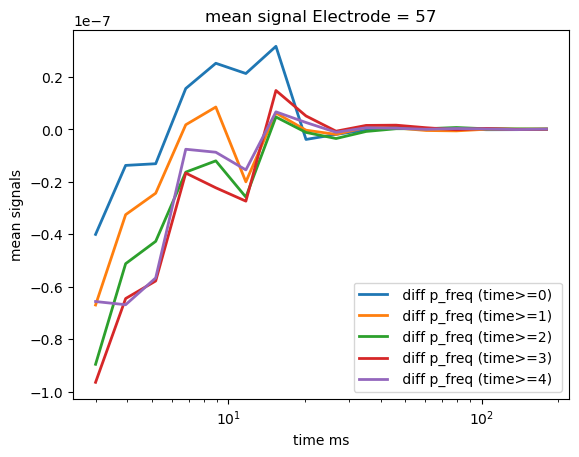

In [131]:
low_val = 4
high_val = 7


for electrode in [1,57]:
    
    
    for time_bin  in range(5):
        
        temp_high = time_window_frequency_data[:,np.array(valences).flatten()>=high_val,:,:]
        temp_low = time_window_frequency_data[:,np.array(valences).flatten()<=low_val,:,:]

        temp_high = temp_high[:,:,electrode,time_bin]
        temp_low = temp_low[:,:,electrode,time_bin]
        
    
        mean_temp_h = np.mean(temp_high,1)
        mean_temp_l = np.mean(temp_low,1)

        
        temp_diff = mean_temp_h-mean_temp_l

        
        plt.plot(freqs, temp_diff,
                     linewidth=2, label=f" diff p_freq (time>={time_bin}) ")
        

    plt.xscale('log')
    #plt.yscale('symlog')


    plt.ylabel('mean signals')
    plt.xlabel('time ms')
    plt.legend()
    plt.title(f'mean signal Electrode = {electrode}')
    plt.show()

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4014107/

-suggest that meaning comes only after at least 400 ms 
-Their word selection are more extreme (ex. vomit) most of our word are neutral
-Amplitude based (no frequency)

methods: N100 (63–86 ms), P100 (113–152 ms) and EPN (207–266 ms). For these early components, we selected nine posterior electrodes that exhibited particularly clear-cut components in the time windows of interest. As shown in Figure 2, these nine electrodes covered the occipital region and were organized in three areas (left lateral, midline and right lateral) of three electrodes each (PO7-PO3-O1, POz-Oz-Iz and PO4-O2-PO8, respectively). Thus, for the early components, data were analyzed in a three-factorial analysis of variance (ANOVA) with emotion, area and electrode as factors.

For the later and more anterior components, three time windows were chosen to capture the P200 (184–277 ms), N400 (344–465 ms) and LPC (492–656 ms) components. These time segments were chosen because their shape, polarity and timing corresponded to the classical components described in related studies (e.g. Kissler et al., 2006). To cover a large part of the scalp in the analyses, we defined a grid that was composed of nine columns going from left lateral to right lateral and five rows going from frontal to parietal (Figure 2). Thus, using this 9 × 5 grid, the data were analyzed in three-way ANOVAs with emotion (disgust vs neutral), laterality (nine columns) and anterior–posterior extent (five rows) as within-subject factors.




https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4773610/

-time windows : 225-290ms , 290-375 ms,  375-670 ms 
- No stimulus type effects were observed for time windows 65-110 ms and 110-225 ms.
- Amplitude based

This paper presents behavioral and event-related potential (ERP) correlates of emotional word processing during a lexical decision task (LDT). We showed that valence and origin (two distinct affective properties of stimuli) help to account for the ERP correlates of LDT. The origin of emotion is a factor derived from the emotion duality model. This model distinguishes between the automatic and controlled elicitation of emotional states. The subjects’ task was to discriminate words from pseudo-words. The stimulus words were carefully selected to differ with respect to valence and origin whilst being matched with respect to arousal, concreteness, length and frequency in natural language. Pseudo-words were matched to words with respect to length. The subjects were 32 individuals aged from 19 to 26 years who were invited to participate in an EEG study of lexical decision making. They evaluated a list of words and pseudo-words. We found that valence modulated the amplitude of the FN400 component (290–375 ms) at centro-frontal (Fz, Cz) region, whereas origin modulated the amplitude of the component in the LPC latency range (375–670 ms). The results indicate that the origin of stimuli should be taken into consideration while deliberating on the processing of emotional words.



https://pubmed.ncbi.nlm.nih.gov/10402254/

-paper that contains the time windows initialy
-this is for visual stimuli so the time window can be a lot different in our case




https://doi.org/10.1016/j.ijpsycho.2005.01.002

- there is probably an effect that if the word is heard a second time the response will be quite different emotionally 

However, behavioral psychological studies have suggested that negative words can be recognized more accurately than positive and neutral words. This study aimed to examine whether, and if so how, the valence of words could influence accuracy and event-related potentials (ERPs) in a recognition task. ERPs were recorded from 20 healthy subjects during performance of a word recognition task. We found a behavioral advantage in discriminability between old and new items for negative words. As for ERPs, the positive-going shift was evident for correct responses to targets in late latency at midline and left centro-parietal sites.


In [20]:
def CreateDataset_v3(subjects, electrodes, freqs, avg_ref=False, ref_region_idx=None,
                 log_power=False, zscore=False, exp='ltpFR2',
                 bin_elecs=True, internal_bipolar=False, use_pairs=True,
                 elec_masks=False, debug=False):

    buf_ms = 1000
    range_left_ms = 0
    range_right_ms = 1600
    morlet_reps = 6
    subject_rec_state = []
    subject_log_power = []
    subject_valence = []
    subject_avg = []

    
    for sub in subjects:
        df_sub = SubjectDataFrames(sub, exp).iloc[:1] if debug else SubjectDataFrames(sub, exp)
        
        
        sub_rec_powers = np.zeros(len(freqs))
        sub_nrec_powers = np.zeros(len(freqs))
        
        
        session_log_power = [] 
        session_rec_state = [] 
        session_valence = [] 
        session_avg = [] 
        
        first_run = True
        first_channel_flags = None
        num_channels_found = 0
        df_per_sub = 0
        mask_index = -1
        
        
        
        for row in df_sub.itertuples():
            mask_index += 1
            try:
                reader = CMLReadDFRow(row)
                evs = reader.load('events')
                enc_evs = evs[evs.type=='WORD']
               
                if use_pairs: scheme = reader.load('pairs')
                else:
                    if row.experiment in ['FR1', 'catFR1']: 
                        scheme = reader.load('contacts')
                    else: scheme = None
                    
                    
                eeg = reader.load_eeg(events=enc_evs, rel_start=-range_left_ms - buf_ms, \
                    rel_stop=range_right_ms + buf_ms, clean=True, scheme=scheme)
                
                if len(eeg.events) != enc_evs.shape[0]:
                    raise IndexError(str(len(eeg.events)) + ' eeg events for ' + \
                                     str(enc_evs.shape[0]) + ' encoding events')
            
                if avg_ref:
                    if ref_region_idx is not None:
                        # reference to average of regional averages
#                         print('region-weighted average referencing')
                        avg_ref_data = np.zeros((eeg.data.shape[0], eeg.data.shape[2]))  # events x time
                        num_regions = 0
                        for sess_reg_idx in ref_region_idx:
                            reg_mask = sess_reg_idx[mask_index]  # get region mask for session
                            if sum(reg_mask) < 5: continue
#                             print('here', reg_mask)
                            if isinstance(reg_mask, np.ndarray): reg_mask = reg_mask.tolist()
#                             print('here2')
                            avg_ref_data += eeg.data[:,reg_mask,:].mean(axis=1)  # add in regional average
#                             print(avg_ref_data.shape)
                            num_regions += 1
                        avg_ref_data /= num_regions
                    else:
                        # Reference to average
                        avg_ref_data = np.mean(eeg.data, (1))
                    for i in range(eeg.data.shape[1]):
                        eeg.data[:,i,:] = eeg.data[:,i,:] - avg_ref_data
                
                if internal_bipolar:
                    # Bipolar reference to nearest labeled electrode
                    eeg.data -= np.roll(eeg.data, 1, 1)

                sr = eeg.samplerate
                print('sampling rate (Hz)',sr)
            
                eeg_ptsa = eeg.to_ptsa()
                valences = get_val(df_val, eeg_ptsa, eeg_ptsa.item_name.values )
            
                del eeg
                
                channels = eeg_ptsa.channel.values
                channel_flags = [( True) for c in channels]
                
                
               
                eeg_chan = eeg_ptsa[:,channel_flags,:]
#                 print('after eeg_chan')
                del eeg_ptsa
                
                freq_range = [58., 62.]
                b_filter = ButterworthFilter(freq_range=freq_range, filt_type='stop', order=4)
                eeg_filtered = b_filter.filter(eeg_chan)
                del eeg_chan
                
#                 print(eeg_filtered.time)
                wf = morlet.MorletWaveletFilter(freqs=freqs, width=morlet_reps, 
                                                output='power', complete=True)
                powers_plusbuf = wf.filter(eeg_filtered)
            
            

                time_window_average = [[65,110],[110,225],[225,290],[290,375],[375,670] ]    

                #remove buffer
                eeg_filtered_nobuff = eeg_filtered[:, :, int((buf_ms/1000)*sr):-1*int((buf_ms/1000)*sr)]
                # event: 576 channel: 124 time: 801
                nb_time = eeg_filtered_nobuff.shape[2]
                time_window_average_id = [  [ int(nb_time*tw[0]/range_right_ms),int(nb_time*tw[1]/range_right_ms) ]   for tw in time_window_average] 
                time_window_average_data = [ np.mean(eeg_filtered_nobuff[:,:, tw[0]:tw[1]], 2) for tw in time_window_average_id] 
                time_window_average_data = np.stack(time_window_average_data,2)


                powers = powers_plusbuf[:, :, :, int((buf_ms/1000)*sr):-1*int((buf_ms/1000)*sr)]
                time_window_frequency_data = [ np.mean(powers[:,:,:, tw[0]:tw[1]], 3) for tw in time_window_average_id] 
                time_window_frequency_data  = np.stack(time_window_frequency_data,3)
                
                session_log_power.append(time_window_frequency_data)
                session_rec_state.append(enc_evs.recalled.tolist())
                session_valence.append(valences)
                session_avg.append(time_window_average_data)
    
            except Exception as e:
                print(e)
                print("problem")
                LogDFException(row, e)
                for pp in range(10):
                    print(e)
                
                if debug: raise e       
        
        subject_rec_state.append(session_rec_state)
        subject_log_power.append(session_log_power)      
        subject_valence.append(session_valence)
        subject_avg.append(session_avg)
        
        with open('data.pickle_v5', 'wb') as handle:
            pickle.dump((subject_rec_state,subject_log_power,subject_valence,subject_avg ), handle)
        
    return (subject_log_power, subject_rec_state, subject_valence, subject_avg)

In [ ]:
subs = df[df['experiment']=='ltpFR2']['subject'].unique()[6:-1]
freqs = np.logspace(np.log10(3), np.log10(180),16)
subject_log_power, subject_rec_state, subject_valence, subject_avg =  CreateDataset_v3(subs, [], freqs, use_pairs=False)

Opening raw data file /protocols/ltp/subjects/LTP133/experiments/ltpFR2/sessions/0/ephys/current_processed/LTP133 20140822 1431.1_clean_raw.fif...
    Range : 0 ... 3311305 =      0.000 ...  6622.610 secs
Ready.
Reading 0 ... 3311305  =      0.000 ...  6622.610 secs...
576 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 576 events and 1801 original time points ...
0 bad epochs dropped
sampling rate (Hz) 500
name 'df_val' is not defined
problem
2023-04-22_22-41-00: Sub: LTP133, Exp: ltpFR2, Sess: 0, NameError, name 'df_val' is not defined
name 'df_val' is not defined
name 'df_val' is not defined
name 'df_val' is not defined
name 'df_val' is not defined
name 'df_val' is not defined
name 'df_val' is not defined
name 'df_val' is not defined
name 'df_val' is not defined
name 'df_val' is not defined
name 'df_val' is not defined
Opening raw data file /protocols/ltp/subjects/LTP133/experiments/ltpFR2/sessions/1/ephys/curre

In [ ]:
print("gggggggffdd")

In [156]:
subject_avg[0][0].shape

(576, 124, 5)

In [583]:
X_Y_pairs = []
#(subject_log_power, subject_rec_state, subject_valence, subject_avg)

for sub in range(len(subject_rec_state)):
    
    all_session = subject_log_power[sub]
    all_session_avg = subject_avg[sub]


    all_session_y = subject_valence[sub]
    
    all_session_concatenated = []
    all_session_concatenated_avg = []
    all_session_concatenated_y = []
    
    for sess in range(len(all_session)):
        one_session = all_session[sess]
        one_session_avg = all_session_avg[sess]
        one_session_y = all_session_y[sess]
        
        n_freqs = one_session.shape[0]
        n_events = one_session.shape[1]
        n_elecs = one_session.shape[2]
        n_timebin = one_session.shape[3]
    
        
        one_session.transpose(1,0,2,3)
        one_session = one_session.reshape(n_events, n_freqs*n_elecs*n_timebin)
        one_session_avg = one_session_avg.reshape(n_events, n_elecs*n_timebin)
        
        new_y = np.array(one_session_y).flatten()
        
        if type(new_y[0]) == pd.core.series.Series:
            print("we don't have the valence must drop")
            
        else:
            all_session_concatenated_y.append(new_y) 
            all_session_concatenated.append( stats.zscore(one_session,0))
            all_session_concatenated_avg.append( stats.zscore(one_session_avg,0))
            
    X_Y_pairs.append([all_session_concatenated,all_session_concatenated_avg, all_session_concatenated_y])

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


we don't have the valence must drop


In [445]:
Xlist,X2list ,Ylist = X_Y_pairs[0]
Xlist = X2list


#corr = np.array([np.corrcoef(Xlist[1][:,v], y=Ylist[1])[0,1] for v in range(Xlist[1].shape[1])])
#idz =np.where(np.abs(corr)>0.00)[0]


selector = SelectKBest(f_classif, k=300).fit(Xlist[1], Ylist[1])


X_test = selector.transform(Xlist[0])
Y_test = Ylist[0]

X_train = [ selector.transform(Xlist[j]) for j in range(2,len(Xlist)) ]
Y_train = [Ylist[j] for j in range(2,len(Ylist)) ] 


lr_ridge = linear_model.LinearRegression()
lr_ridge.fit(np.concatenate(X_train), np.concatenate(Y_train))
predicted = lr_ridge.predict(X_test)



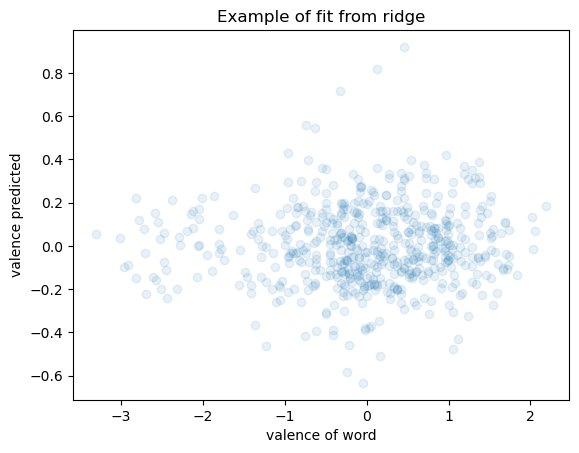

In [446]:
plt.plot(Y_test,predicted,'o', alpha=0.1)
plt.title("Example of fit from ridge")
plt.ylabel("valence predicted")
plt.xlabel("valence of word")
plt.show()

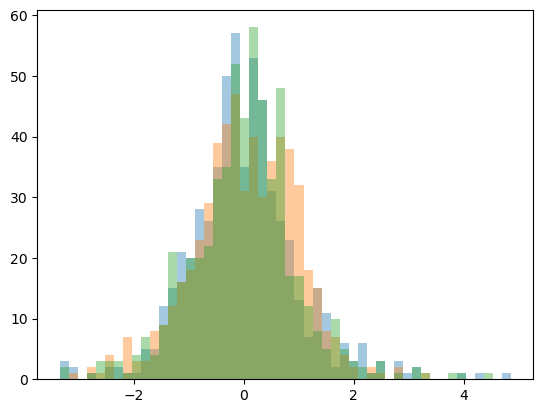

In [461]:
rrr = plt.hist(Xlist[0][:,7], bins=50, alpha=0.4)
plt.hist(Xlist[2][:,7], bins=rrr[1], alpha=0.4)
plt.hist(Xlist[3][:,7], bins=rrr[1], alpha=0.4)
plt.show()

In [625]:
Xlist,X2list ,Ylist = X_Y_pairs[0]
Xlist = Xlist



#pca = PCA(n_components=10)
#pca.fit(np.concatenate(Xlist))

#selector = SelectKBest(f_classif, k=10).fit(Xlist[1], Ylist[1])

X_test = pca.transform(np.concatenate( [Xlist[0],Xlist[1] ]))
Y_test = np.concatenate( [Ylist[0],Ylist[1] ])


X_train = np.concatenate([ pca.transform(Xlist[j]) for j in range(2,len(Ylist)-1) ])
Y_train = np.concatenate([Ylist[j] for j in range(2,len(Ylist)-1) ])


Y_test = np.subtract(Y_test,5)
Y_train = np.subtract(Y_train,5)


#X_train = X_train[ np.logical_or((Y_train < -1 ) ,(Y_train >1 )),:]
#Y_train = Y_train[ np.logical_or((Y_train < -1 ) ,(Y_train >1 ))]
#X_test = X_test[np.logical_or((Y_test < -1 ) ,(Y_test >1 )),:]
#Y_test = Y_test[np.logical_or((Y_test < -1 ) ,(Y_test >1 ))]


rf = RandomForestRegressor(n_estimators=1000, max_depth=12, bootstrap = True, max_samples = 3000)
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=3000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [626]:
predicted = rf.predict(X_train)
score = rf.score(X_train,Y_train)

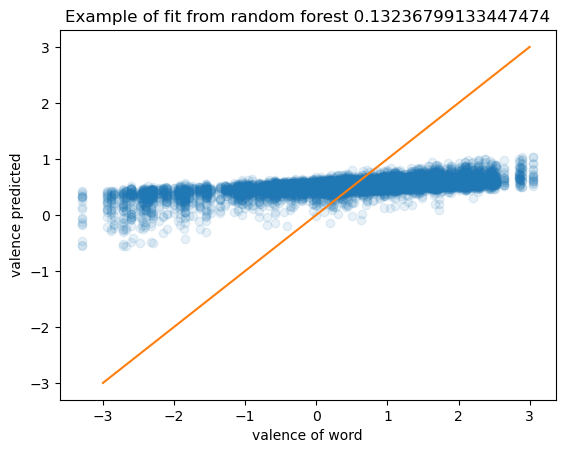

In [627]:
plt.plot(Y_train,predicted,'o', alpha=0.1)
plt.plot([-3,3],[-3,3])
plt.title(f"Example of fit from random forest {score}")
plt.ylabel("valence predicted")
plt.xlabel("valence of word")
plt.show()

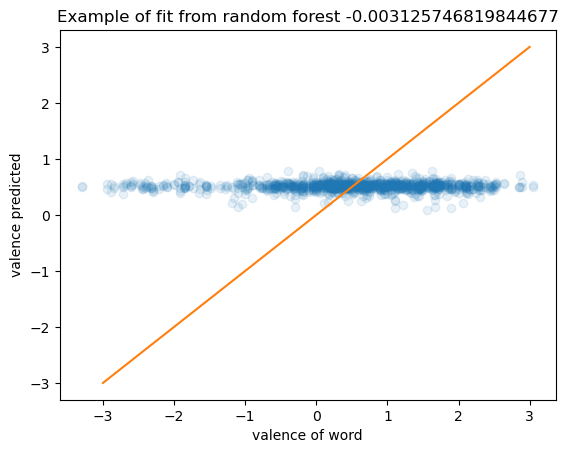

In [629]:
predicted = rf.predict(X_test)
score = rf.score(X_test, Y_test)
plt.plot(Y_test,predicted,'o', alpha=0.1)
plt.plot([-3,3],[-3,3])
plt.title(f"Example of fit from random forest {score}")
plt.ylabel("valence predicted")
plt.xlabel("valence of word")
plt.show()


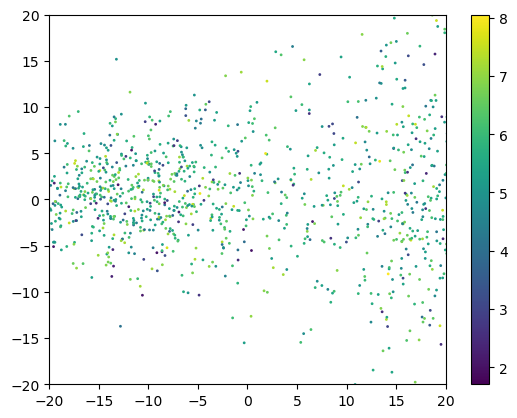

In [612]:

pca = PCA(n_components=2)
pca.fit(np.concatenate(Xlist))
#pca = SelectKBest(f_classif, k=30).fit(np.concatenate(Xlist), np.concatenate(Ylist))



X_train = np.concatenate([ pca.transform(Xlist[j]) for j in range(2,len(Ylist)-1) ])
Y_train = np.concatenate([Ylist[j] for j in range(2,len(Ylist)-1) ])


plt.scatter(x = X_train[:,0], y = X_train[:,1], c =Y_train , alpha =1, s=1)
plt.xlim((-20,20))
plt.ylim((-20,20))
plt.colorbar()
plt.show()



In [ ]:
Xlist,X2list ,Ylist = X_Y_pairs[0]


In [81]:
np.sum(Y_train==1)/len(Y_train) /(np.sum(Y_train==0)/len(Y_train))

1.793103448275862

In [82]:
Xlist,X2list ,Ylist = X_Y_pairs[0]

Xlist = [ np.concatenate((Xlist[sess], X2list[sess] ), 1)  for sess in range(len(Xlist))] 

pca = PCA(n_components=15)
pca.fit(np.concatenate(Xlist))

X_test, Y_test = prepareX([Xlist[0],Xlist[1]], [Ylist[0],Ylist[1]], pca, lower = 6 , higher = 6 )

X_train, Y_train = prepareX([Xlist[j] for j in range(2,len(Ylist)-1) ], 
                            [Ylist[j] for j in range(2,len(Ylist)-1) ], pca, lower = 6 , higher = 6 )


val1 = np.sum(Y_train==1)/len(Y_train)
val0 = np.sum(Y_train==0)/len(Y_train)


sample_weight = np.array([val0/val1 if i == 1 else 1 for i in Y_train])

rf = RandomForestClassifier(n_estimators=400, max_depth=7, bootstrap = True, max_samples = 1000)
rf.fit(X_train, Y_train,sample_weight=sample_weight)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=1000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

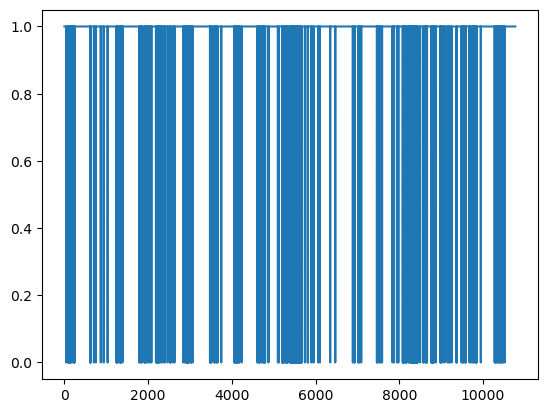

0.6680590364800891


In [83]:
predicted = rf.predict(X_train)
score = rf.score(X_train,Y_train)
plt.plot(predicted)
plt.show()
print(score)

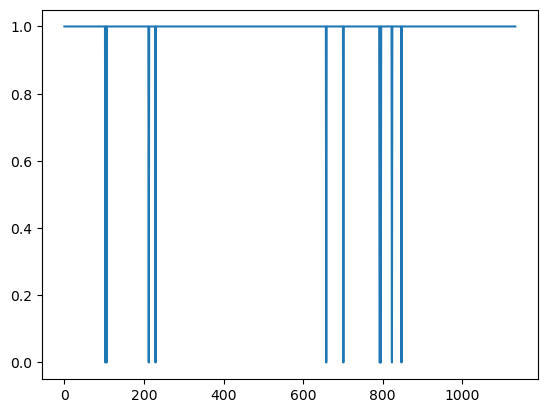

0.6358024691358025


In [84]:
predicted = rf.predict(X_test)
score = rf.score(X_test,Y_test)
plt.plot(predicted)
plt.show()
print(score)

In [85]:
clf_report = classification_report(Y_test, predicted, output_dict=True)
clf_report

{'0': {'precision': 0.18181818181818182,
  'recall': 0.0049261083743842365,
  'f1-score': 0.00959232613908873,
  'support': 406},
 '1': {'precision': 0.6402493321460374,
  'recall': 0.9876373626373627,
  'f1-score': 0.7768773635872501,
  'support': 728},
 'accuracy': 0.6358024691358025,
 'macro avg': {'precision': 0.41103375698210964,
  'recall': 0.49628173550587346,
  'f1-score': 0.39323484486316945,
  'support': 1134},
 'weighted avg': {'precision': 0.47611966104100273,
  'recall': 0.6358024691358025,
  'f1-score': 0.5021703748712417,
  'support': 1134}}

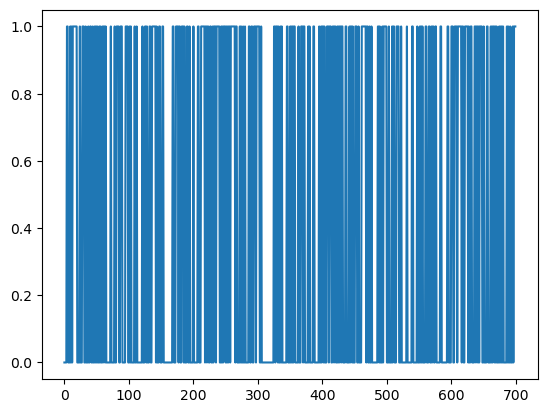

In [45]:
plt.plot(Y_test)
plt.show()

In [ ]:
clf_report = classification_report(Y_test, predicted, output_dict=True)

In [24]:
with open('zdata/data.pickle_part1', 'rb') as handle:
    datap1 = pickle.load(handle)
with open('zdata/data.pickle_part2', 'rb') as handle:
    datap2 = pickle.load(handle)
with open('zdata/data.pickle_part3', 'rb') as handle:
    datap3 = pickle.load(handle)

In [25]:
subject_rec_state,subject_log_power,subject_valence,subject_avg  = [],[],[],[]

subject_rec_state.extend(datap1[0])
subject_rec_state.extend(datap2[0])
subject_rec_state.extend(datap3[0])

subject_log_power.extend(datap1[1])
subject_log_power.extend(datap2[1])
subject_log_power.extend(datap3[1])

subject_valence.extend(datap1[2])
subject_valence.extend(datap2[2])
subject_valence.extend(datap3[2])

subject_avg.extend(datap1[3])
subject_avg.extend(datap2[3])
subject_avg.extend(datap3[3])

X_Y_pairs = []
#(subject_log_power, subject_rec_state, subject_valence, subject_avg)

for sub in range(len(subject_rec_state)):
    
    all_session = subject_log_power[sub]
    all_session_avg = subject_avg[sub]


    all_session_y = subject_valence[sub]
    
    all_session_concatenated = []
    all_session_concatenated_avg = []
    all_session_concatenated_y = []
    
    for sess in range(len(all_session)):
        one_session = all_session[sess]
        one_session_avg = all_session_avg[sess]
        one_session_y = all_session_y[sess]
        
        n_freqs = one_session.shape[0]
        n_events = one_session.shape[1]
        n_elecs = one_session.shape[2]
        n_timebin = one_session.shape[3]
    
        
        one_session.transpose(1,0,2,3)
        one_session = one_session.reshape(n_events, n_freqs*n_elecs*n_timebin)
        one_session_avg = one_session_avg.reshape(n_events, n_elecs*n_timebin)
        
        new_y = np.array(one_session_y).flatten()
        
        if type(new_y[0]) == pd.core.series.Series:
            print("we don't have the valence must drop")
            
        else:
            all_session_concatenated_y.append(new_y) 
            all_session_concatenated.append( stats.zscore(one_session,0))
            all_session_concatenated_avg.append( stats.zscore(one_session_avg,0))
            
    X_Y_pairs.append([all_session_concatenated,all_session_concatenated_avg, all_session_concatenated_y])

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop
we don't have the valence must drop


In [26]:
import itertools

In [86]:
def prepareX(Xdata, Ydata, pca_model, lower = 6 , higher = 6 ):
    
    if isinstance(Xdata, list):
        Xdata = np.concatenate(Xdata)
        Ydata = np.concatenate(Ydata)
                   
    X_pca = pca_model.transform(Xdata)
    X_sel = Xdata[ np.logical_or((Ydata<lower) ,(Ydata>higher)),:]
    Y_sel = Ydata[ np.logical_or((Ydata<lower) ,(Ydata >higher))]
    Y_sel = Y_sel<=lower
    Y_sel = Y_sel.astype(int)
    
    return X_sel, Y_sel

In [93]:
import random

[2, 1, 3, 4]

In [ ]:
n_estimators=[100,400,800]
max_depth = [4,5,6]
pca_n = 15


result_score = [] #contain 


param_list = list(itertools.product(n_estimators,max_depth))


for sub in range(1,len(X_Y_pairs)):
    
    Xlist1, Xlist2 ,Ylist = X_Y_pairs[sub]
    Xlist = [ np.concatenate((Xlist1[sess], Xlist2[sess] ), 1)  for sess in range(len(Xlist1))] 
    
    pca = PCA(n_components=pca_n)
    pca.fit(np.concatenate(Xlist))

    score_sub_optim = []

    
    
    for k in random.sample(list(range(len(Xlist))),3):

        X_test = Xlist[k]
        Y_test = Ylist[k]
        X_train = [Xlist[j] for j in range(len(Xlist)) if j!=k]
        Y_train = [Ylist[j] for j in range(len(Ylist)) if j!=k]  
        param_score = [[] for param in param_list]

        for l in random.sample(list(range(len(X_train))),3):

            X_val_inner = Xlist[l]
            Y_val_inner = Ylist[l]
            X_train_inner = [X_train[j] for j in range(len(X_train)) if j!=l]
            Y_train_inner = [Y_train[j] for j in range(len(Y_train)) if j!=l]

            for ind_param, (n_est, depth) in enumerate(param_list):

                rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, bootstrap = True, max_samples = 1000)
                X_train_inner_sel, Y_train_inner_sel = prepareX(X_train_inner, 
                                                                    Y_train_inner, pca)
                
                val1 = np.sum(Y_train_inner_sel==1)/len(Y_train_inner_sel)
                val0 = np.sum(Y_train_inner_sel==0)/len(Y_train_inner_sel)
                print(val1)
                sample_weight = np.array([val0/val1 if i == 1 else 1 for i in Y_train_inner_sel])
                
                rf.fit(X_train_inner_sel, Y_train_inner_sel, sample_weight=sample_weight)
                
                X_val_inner_sel, Y_val_inner_sel = prepareX(X_val_inner, 
                                                                    Y_val_inner, pca)
                
                score_inner = rf.score(X_val_inner_sel, Y_val_inner_sel)
                print(n_est, depth,score_inner)
                param_score[ind_param].append(score_inner)

                
        param_score = [sum(param_score[param_ind]) for param_ind in range(len(param_list))]
        best_param = param_list[param_score.index(max(param_score))]

        
        rf = RandomForestClassifier(n_estimators=best_param[0], max_depth=best_param[1], bootstrap = True, max_samples = 1000)
        X_train_sel, Y_train_sel = prepareX(X_train, Y_train, pca)
        
        val1 = np.sum(Y_train_sel==1)/len(Y_train_sel)
        val0 = np.sum(Y_train_sel==0)/len(Y_train_sel)
        sample_weight = np.array([val0/val1 if i == 1 else 1 for i in Y_train_sel])
        
        rf.fit(X_train_sel, Y_train_sel, sample_weight=sample_weight)
        
        X_test_sel, Y_test_sel = prepareX(X_test, Y_test, pca)

        score = rf.score(X_test_sel, Y_test_sel)
        clf_report = classification_report(Y_test_sel, rf.predict(X_test_sel), output_dict=True)
        
        score_sub_optim.append((sub,k,best_param,score,clf_report,param_score ))

    result_score.append(score_sub_optim)
            
    with open('result_score_part2.pickle', 'wb') as handle:
        pickle.dump(result_score, handle)
 

0.6419753086419753
100 4 0.6349206349206349
0.6419753086419753
100 5 0.6631393298059964
0.6419753086419753
100 6 0.6701940035273368
0.6419753086419753
400 4 0.6613756613756614
0.6419753086419753
400 5 0.6613756613756614
0.6419753086419753
400 6 0.671957671957672
0.6419753086419753
800 4 0.6596119929453262
0.6419753086419753
800 5 0.6948853615520282
0.6419753086419753
800 6 0.6984126984126984
0.6419753086419753
100 4 0.6419753086419753
0.6419753086419753
100 5 0.656084656084656
0.6419753086419753
100 6 0.7019400352733686
0.6419753086419753
400 4 0.7072310405643739
0.6419753086419753
400 5 0.7072310405643739
0.6419753086419753
400 6 0.7266313932980599
0.6419753086419753
800 4 0.7178130511463845
0.6419753086419753
800 5 0.7142857142857143
0.6419753086419753
800 6 0.689594356261023
0.6419753086419753
100 4 0.6578483245149912
0.6419753086419753
100 5 0.6984126984126984
0.6419753086419753
100 6 0.689594356261023
0.6419753086419753
400 4 0.656084656084656
0.6419753086419753
400 5 0.6613756613

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6419753086419753
100 4 0.5890652557319224
0.6419753086419753
100 5 0.6296296296296297
0.6419753086419753
100 6 0.6190476190476191
0.6419753086419753
400 4 0.6507936507936508
0.6419753086419753
400 5 0.6402116402116402
0.6419753086419753
400 6 0.6419753086419753
0.6419753086419753
800 4 0.6437389770723104
0.6419753086419753
800 5 0.6419753086419753
0.6419753086419753
800 6 0.6419753086419753
0.6419753086419753
100 4 0.6067019400352733
0.6419753086419753
100 5 0.6313932980599647
0.6419753086419753
100 6 0.6631393298059964
0.6419753086419753
400 4 0.673721340388007
0.6419753086419753
400 5 0.6437389770723104
0.6419753086419753
400 6 0.6825396825396826
0.6419753086419753
800 4 0.6578483245149912
0.6419753086419753
800 5 0.6596119929453262
0.6419753086419753
800 6 0.7107583774250441
0.6419753086419753
100 4 0.5520282186948854
0.6419753086419753
100 5 0.6208112874779541
0.6419753086419753
100 6 0.6208112874779541
0.6419753086419753
400 4 0.6507936507936508
0.6419753086419753
400 5 0.634920

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6419753086419753
100 4 0.6278659611992945
0.6419753086419753
100 5 0.6313932980599647
0.6419753086419753
100 6 0.6313932980599647
0.6419753086419753
400 4 0.6331569664902998
0.6419753086419753
400 5 0.6402116402116402
0.6419753086419753
400 6 0.6437389770723104
0.6419753086419753
800 4 0.6384479717813051
0.6419753086419753
800 5 0.6402116402116402
0.6419753086419753
800 6 0.6419753086419753
0.6419753086419753
100 4 0.5555555555555556
0.6419753086419753
100 5 0.6067019400352733
0.6419753086419753
100 6 0.6313932980599647
0.6419753086419753
400 4 0.63668430335097
0.6419753086419753
400 5 0.6349206349206349
0.6419753086419753
400 6 0.6402116402116402
0.6419753086419753
800 4 0.6384479717813051
0.6419753086419753
800 5 0.6437389770723104
0.6419753086419753
800 6 0.6419753086419753
0.6419753086419753
100 4 0.41975308641975306
0.6419753086419753
100 5 0.6437389770723104
0.6419753086419753
100 6 0.3985890652557319
0.6419753086419753
400 4 0.6172839506172839
0.6419753086419753
400 5 0.627865

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6419753086419753
100 4 0.6190476190476191
0.6419753086419753
100 5 0.6631393298059964
0.6419753086419753
100 6 0.6790123456790124
0.6419753086419753
400 4 0.6437389770723104
0.6419753086419753
400 5 0.6472663139329806
0.6419753086419753
400 6 0.6419753086419753
0.6419753086419753
800 4 0.6419753086419753
0.6419753086419753
800 5 0.6437389770723104
0.6419753086419753
800 6 0.6419753086419753
0.6419753086419753
100 4 0.6684303350970018
0.6419753086419753
100 5 0.6684303350970018
0.6419753086419753
400 4 0.6596119929453262
0.6419753086419753
400 5 0.6437389770723104
0.6419753086419753
400 6 0.6490299823633157
0.6419753086419753
800 4 0.6472663139329806
0.6419753086419753
800 5 0.6419753086419753
0.6419753086419753
800 6 0.6437389770723104
0.6419753086419753
100 4 0.5749559082892416
0.6419753086419753
100 5 0.6490299823633157
0.6419753086419753
100 6 0.6437389770723104
0.6419753086419753
400 4 0.6296296296296297
0.6419753086419753
400 5 0.6684303350970018
0.6419753086419753
400 6 0.67195

In [91]:
with open('result_score.pickle', 'wb') as handle:
    pickle.dump(result_score, handle)

[0.13803243 0.08364981]


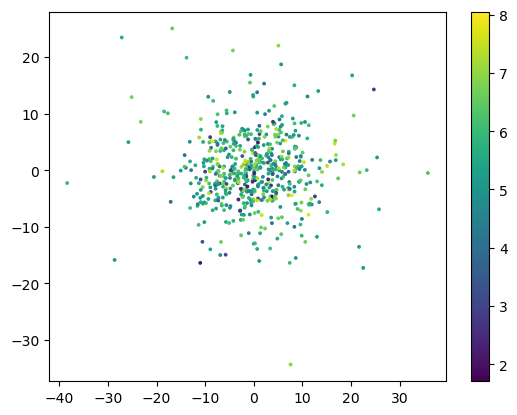

In [44]:

Xlist1, Xlist2 ,Ylist = X_Y_pairs[0]
Xlist = [ np.concatenate((Xlist1[sess], Xlist2[sess] ), 1)  for sess in range(len(Xlist1))] 




pca = PCA(n_components=2)
pca.fit(np.concatenate(Xlist2))
#pca = SelectKBest(f_classif, k=30).fit(np.concatenate(Xlist), np.concatenate(Ylist))




print(pca.explained_variance_ratio_)

Xtrans = pca.transform(Xlist2[0])

plt.scatter(x = Xtrans[:,0], y = Xtrans[:,1], c =Ylist[0] , alpha =1, s=3)

plt.colorbar()
plt.show()

In [68]:
with open('zdata/result_score_part2.pickle', 'rb') as handle:
    score1 = pickle.load(handle)


In [71]:
sub = 0
run = 0

means = []
stds = []



for sub in range(len(score1)):
    
    sub_score = []
    
    for run in range(len(score1[sub])):
        
        print(sub,run )
        subl,kl,best_param,score,clf_report,param_score  = score1[sub][run]
        
        sub_score.append(clf_report['weighted avg']['recall'])
    
    
    means.append(np.mean(sub_score)) 
    stds.append(np.std(sub_score)) 


0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2
5 0
5 1
5 2
6 0
6 1
6 2
7 0
7 1
7 2
8 0
8 1
8 2


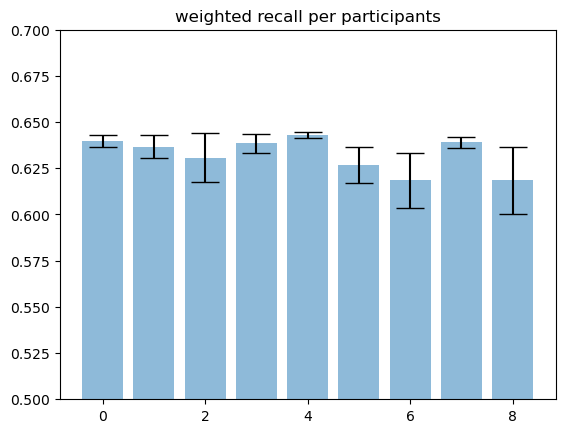

In [77]:
plt.bar(list(range(9)), means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylim(0.5,0.7)
plt.title('weighted recall per participants')
plt.show()